## WGAN2vec: reimplementing Generative Adversarial Network for text generation

This notebook tries to implement a GAN model proposed by Akshay Budhkar, et. al in the paper [Generative Adversarial Networks for text using word2vec intermediaries](https://arxiv.org/abs/1904.02293) (2019). Basically, authors make attempt to generate coherent sentences in the form of word embeddings using Generative Adversarial Network, while evaluating model performance by converting generated embeddings into text based on cosine similarity (nearest neighbors approach). The algorithm is as follows:

![Замещающий текст](https://drive.google.com/uc?id=1g0MLMrhlKWaVvWUfJfhu65_vqV8XtCWL)

And general framework structure looks like this:
![Замещающий текст](https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_14%2Fproject_348561%2Fimages%2Fx1.png)

Official code wasn't released by the authors yet, and the only [unofficial attempt](https://github.com/adventure2165/GAN2vec/blob/master/GAN2vec.ipynb) to implement the paper ended up with mode collapse (Generator managed to produce only 2 almost indentical sentences).

Despite the fact that the paper describes overall model architecture and training algorithm in pretty straightforward manner, specific hyperparameters choices weren't covered. It has led to a great level of ambiguity as GANs are highly sensitive to any architecture modifications in both Generator and Discriminator. Kernel sizes in transposed and regular convolutional layers used in this notebook are the same as in the mentioned impementation (basic GAN framework code implementation was taken from [this post](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f) regarding generating MNIST-like images).

In order to prevent mode collapse, some changes were made to the original proposition. Namely:
1. Traditional GAN training algorithm was replaced by [Wasserstein GAN (WGAN)](https://arxiv.org/abs/1701.07875)![Замещающий текст](https://wiseodd.github.io/img/2017-02-04-wasserstein-gan/00.png).

  This involved changes in calculation of D and G losses, D architecture (no `Sigmoid` activation for output), training iterations, learning and decay rates, D weight clipping, and optimizer type.
2. In order for discriminator to learn to distinguish between coherent and non-coherent sentences (and not only check for correct distribution of generated data) it was pretrained on the trained corpus splitted into original sentences and sentences with two random words swapped.
3. Learning rate for Generator is `10` times bigger than that of Discriminator.
4. Number of epochs is reduced to `50`.
5. Randpm noise size is increased to `256` instead of `100`.
6. Label smoothing was dismissed.
7. Other minor changes.

As a result, quality of generated senteces is comparable to the original work (w/ a few nuances).



In [ ]:
import torch
from torch import nn, optim
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import TensorDataset, DataLoader

# Preparing data

In [ ]:
sentences = []
train_sen = []
length = []

sent = pd.read_fwf('cmu-se.txt') # CMU-SE dataset

test_sent = [len(i.split(' ')) for i in sent.text]

from collections import Counter
data = Counter(test_sent)

print(data.most_common()) # most common sentence length
print(np.mean(test_sent)) # average sentence length

for i in sent.text:
    splitsent = i.split(' ')
    train_sen.append(splitsent) # add all sentences to train embedding matrix on
    if len(splitsent)>=7: # length <=7
        sentences.append(splitsent[:7])


newdf = pd.DataFrame(columns=['sentence', 'score'])
newdf['sentence'] = sentences
scores = [1 for i in range(len(sentences))]
newdf['score'] = scores

print(newdf.head())
newdf.to_csv('sentences.csv')


[(9, 6104), (8, 6104), (10, 5601), (7, 4572), (11, 4415), (12, 3571), (13, 2712), (6, 2159), (14, 1977), (15, 1408), (5, 1202), (16, 1034), (4, 843), (17, 806), (18, 630), (19, 438), (20, 252), (21, 114), (22, 51), (23, 12), (24, 8), (27, 1), (26, 1), (28, 1)]
10.191793893129772
                                    sentence  score
0         [<s>, can, i, catch, a, bus, that]      1
1     [<s>, is, there, a, train, that, goes]      1
2       [<s>, it, 's, just, down, the, hall]      1
3       [<s>, i, 'll, bring, you, some, now]      1
4  [<s>, if, there, is, anything, else, you]      1


In [ ]:
from gensim.models import Word2Vec
from tqdm import tqdm

tqdm.pandas()

# creating embedding model using gensim library
model = Word2Vec(sentences=train_sen, window=3, min_count=1,
                 sg=1, 
                 size=64,  
                 workers=4)

# closest words to 'nice' based on cosine similarity
model.wv.most_similar('nice')


[('great', 0.8572444319725037),
 ('wonderful', 0.8140026330947876),
 ('beautiful', 0.791840672492981),
 ('happy', 0.7861843109130859),
 ('fun', 0.7811398506164551),
 ('good', 0.7678959369659424),
 ('short', 0.7584840059280396),
 ('easy', 0.7570862174034119),
 ('difficult', 0.7569761872291565),
 ('fine', 0.7553464770317078)]

In [ ]:
import random

print(len(model.wv.vocab.keys())) # number of unique embeddings in dataset

vocabulary = []

for i in sentences:
  for y in i:
    if y not in vocabulary:
      vocabulary.append(y)

print(vocabulary[:20])
print(len(vocabulary)) # number of unique embeddings for sentences of length <=7

# converting text into embeddings
sent_embed = np.array([[model.wv[y] for y in i] for i in sentences])

print(sent_embed[0])

print(sent_embed.shape)

scores = np.array(scores)

swapped = sent_embed[:]
sent_embed = sent_embed.copy()

# randomly choose and swap two words in a sentence
for i in swapped:
  ix1, ix2 = random.sample(range(7),2)
  i[[ix1, ix2]] = i[[ix2, ix1]]

labels_or = [1 for i in range(len(sent_embed))] # labels for original sent
labels_sw = [0 for i in range(len(swapped))] # labels for swapped sent


3382
['<s>', 'can', 'i', 'catch', 'a', 'bus', 'that', 'is', 'there', 'train', 'goes', 'it', "'s", 'just', 'down', 'the', 'hall', "'ll", 'bring', 'you']
3105
[array([ 0.5026043 , -0.11877969, -0.21278767, -0.28328994, -0.38619405,
       -0.5118495 , -0.70265025,  0.15575723,  0.04859247, -0.03327981,
        0.22426291,  0.3735654 , -0.06789776, -0.00084072, -0.49836662,
       -0.06281528, -0.24078196, -0.41670772, -0.14310147,  0.55649465,
        0.452351  , -0.5778672 ,  0.25433573,  0.667421  ,  0.22671475,
        0.0114196 , -0.11681031, -0.267106  , -0.36019355, -0.7776892 ,
       -0.44249654, -0.30586344, -0.6001307 , -0.37484056, -0.09810031,
       -0.13820972, -0.27029476, -0.07680281, -0.05586311, -0.12382992,
        0.05712488, -0.22993648,  0.15259364,  0.4596151 , -0.04355361,
        0.07600249, -0.08006925,  0.4746195 , -0.28124246, -0.24026069,
       -0.02183571, -0.65774655, -0.07671089, -0.5124556 , -0.7806451 ,
       -0.00331289,  0.271424  ,  0.23025703, -0.0

In [ ]:
print(swapped.shape)

print(sent_embed[0]) # first original sentence
print(swapped[0]) # first swapped sentence

print(' '.join([model.wv.most_similar([i], topn=1)[0][0] for i in sent_embed[0]]))
print(' '.join([model.wv.most_similar([i], topn=1)[0][0] for i in swapped[0]]))


(39812, 7, 64)
[[ 5.02604306e-01 -1.18779689e-01 -2.12787673e-01 -2.83289939e-01
  -3.86194050e-01 -5.11849523e-01 -7.02650249e-01  1.55757234e-01
   4.85924669e-02 -3.32798064e-02  2.24262908e-01  3.73565406e-01
  -6.78977594e-02 -8.40717054e-04 -4.98366624e-01 -6.28152788e-02
  -2.40781963e-01 -4.16707724e-01 -1.43101469e-01  5.56494653e-01
   4.52351004e-01 -5.77867210e-01  2.54335731e-01  6.67420983e-01
   2.26714745e-01  1.14195962e-02 -1.16810307e-01 -2.67105997e-01
  -3.60193551e-01 -7.77689219e-01 -4.42496538e-01 -3.05863440e-01
  -6.00130677e-01 -3.74840558e-01 -9.81003121e-02 -1.38209715e-01
  -2.70294756e-01 -7.68028125e-02 -5.58631085e-02 -1.23829924e-01
   5.71248792e-02 -2.29936481e-01  1.52593642e-01  4.59615111e-01
  -4.35536094e-02  7.60024861e-02 -8.00692514e-02  4.74619508e-01
  -2.81242460e-01 -2.40260690e-01 -2.18357109e-02 -6.57746553e-01
  -7.67108947e-02 -5.12455583e-01 -7.80645072e-01 -3.31288506e-03
   2.71423995e-01  2.30257034e-01 -3.30093689e-02  2.92675775

# Model

Generator uses one linear layer to transform from the size of initial random noise and two 2-D fractionally strided convolution layers. Output size is batch size * sentence length * embedding dimension. Two Leaky RELU and batch normalization layers with a single dropout layer have been used to stabilize generated data.

In [ ]:
batch_size = 100
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 256

        self.lin1 = nn.Linear(n_features, 512)
        self.relu = nn.LeakyReLU(0.2)
        self.drop = nn.Dropout(.3)
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=(3,16), stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(256)
        self.norm2 = nn.BatchNorm2d(1)
        self.conv2 = nn.ConvTranspose2d(256, 1, kernel_size=(3,34), stride=2, bias=False)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = self.lin1(x)
        x = x.view(batch_size, 512,1,1)
        x = self.relu(x)
        x = x.float()
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.drop(self.relu(self.norm2(self.conv2(x)))) 

        return x.squeeze(1)
    

Discriminator is somewhat mirrored version of Generator, using 2-D convolutional layers. Note that `Sigmoid` function isn't used due to WGAN loss function that doesn't include logarithm, hence D output isn't a probability but a continious value.

In [ ]:
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 512, kernel_size=(3,64), bias=False)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(512, 64, kernel_size=(5,1), bias=False)
        self.ln1 = nn.Linear(64, 1)
        self.drop = nn.Dropout(.3)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, 7, 64)
        x = x.float()
        x = self.relu(self.conv1(x))
        x = self.drop(self.relu(self.conv2(x)))
        x = x.view(batch_size, -1)
        x = self.ln1(x)
        
        return x


In [ ]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

Optmizer type and learning rates were suggested by WGAN authors

In [ ]:
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=5e-5)
g_optimizer = optim.RMSprop(generator.parameters(), lr=5e-4)

# Loss function for pretraining Discriminator
# We can no longer use BCELoss because of no Sigmoid 
# (BCEWithLogitsLoss is more stable anyway)
loss = nn.BCEWithLogitsLoss()


In [ ]:
print(len(scores))

data = TensorDataset(torch.from_numpy(sent_embed), torch.from_numpy(scores))
data_loader = DataLoader(data, batch_size=100, shuffle=True, drop_last=True)

print(len(data_loader)) # data for pretraining Discriminator

39812
398


In [ ]:
features = np.concatenate([sent_embed, swapped]) # all sentences

print(len(features))

labels = np.concatenate([labels_or,labels_sw])
from sklearn.model_selection import train_test_split

print(len(labels)) # all labels

X_train, X_val, y_train, y_val = train_test_split(features, labels, 
                                                  test_size=0.2, shuffle=True)

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

train_load = DataLoader(train_data, batch_size=100, shuffle=True, drop_last=True)
valid_load = DataLoader(val_data, batch_size=100, shuffle=True, drop_last=True)

print(len(train_load)) # train set size
print(len(valid_load)) # valid set size


79624
79624
636
159


# Pretraining the Discriminator
After 10 epochs we got `90% `validation accuracy on 15,9k sentences.

In [ ]:
from sklearn.metrics import accuracy_score
sig = nn.Sigmoid()
 
optimizer = optim.Adam(discriminator.parameters(), lr=0.01)

for e in range(10):

  train_res = []
  val_res = []
  train_loss = []
  val_loss = []
  train_lab = []
  val_lab = []
    
  for f,l in train_load:
    
    if torch.cuda.is_available():
      f, l = f.cuda(), l.cuda()
    
    discriminator.zero_grad()
    out = discriminator(f)

    for i in out.squeeze().cpu().detach():
      train_res.append(sig(i))
 
    error = loss(out.squeeze(), l.float())

    train_loss.append(error.item())

    for i in l.cpu().detach().numpy():
      train_lab.append(i)
 
    error.backward()
    optimizer.step()
 
  discriminator.eval()
  
  for f_val, l_val in valid_load:
    if torch.cuda.is_available():
      f_val, l_val = f_val.cuda(), l_val.cuda()
    
    out = discriminator(f_val)
 
    for i in out.squeeze().cpu().detach():
      val_res.append(torch.round(sig(i)))
 
    error = loss(out.squeeze(), l_val.float())
    val_loss.append(error.item())

    for i in l_val.cpu().detach().numpy():
      val_lab.append(i)
 
    discriminator.train()
 
    
  print(f'Epoch: {e+1}/10')
  print(f'Train loss: {np.mean(train_loss)}')
  print(f'Valid loss: {np.mean(val_loss)}')
  print(f'Training acc: {accuracy_score(train_lab, np.round(train_res, decimals=0))}')
  print(f'Val acc: {accuracy_score(val_lab, np.round(val_res, decimals=0))}')

Epoch: 1/10
Train loss: 0.4377601215580724
Valid loss: 0.3188376304863384
Training acc: 0.7847798742138364
Val acc: 0.8620754716981132
Epoch: 2/10
Train loss: 0.31364500475754525
Valid loss: 0.27981556014819714
Training acc: 0.8645125786163522
Val acc: 0.8817610062893082
Epoch: 3/10
Train loss: 0.28358919575294983
Valid loss: 0.3205262266052594
Training acc: 0.8831603773584905
Val acc: 0.8621383647798743
Epoch: 4/10
Train loss: 0.2700711311479597
Valid loss: 0.2635579987329507
Training acc: 0.8905503144654088
Val acc: 0.8933333333333333
Epoch: 5/10
Train loss: 0.26373021919631734
Valid loss: 0.2696848105896944
Training acc: 0.892562893081761
Val acc: 0.8934591194968553
Epoch: 6/10
Train loss: 0.2626307132366881
Valid loss: 0.26252703785708864
Training acc: 0.8945597484276729
Val acc: 0.8998113207547169
Epoch: 7/10
Train loss: 0.25074644230962173
Valid loss: 0.2963253044107425
Training acc: 0.9003616352201258
Val acc: 0.8924528301886793
Epoch: 8/10
Train loss: 0.24050932239342784
Valid 

In [ ]:
# random noise of normal distribution
def noise(size):
    n = torch.randn(size, 256)
    if torch.cuda.is_available(): return n.cuda() 
    return n

WGAN adresses a lot of issues that are naturally built in regular GAN: mode collapse, unstable training, failing to converge (e.g. due to gradient vanishing), lack of information about learning process derived from D and G losses (now G loss allows to track progress explicitly). More info could be found in the [original paper](https://arxiv.org/abs/1701.07875), [here](https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/) or [here](https://paper.dropbox.com/doc/Wasserstein-GAN-GvU0p2V9ThzdwY3BbhoP7).

# Training

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):

    optimizer.zero_grad()

    # D prediction for actual sentences
    prediction_real = discriminator(real_batch)
    # D prediction for generated sentences
    prediction_fake = discriminator(fake_data)
    
    """
    WGAN loss for D (now referred to as critic) (update D parameters)
    It utilizes Wasserstein-1 distance and basically shows the difference 
    between D's estimation of generated and real samples quality. 
    In practice, training behaviour is identical to 
    error_d = torch.mean(prediction_real) - torch.mean(prediction_fake)
    given that error_g = torch.mean(prediction).
    Here we add minus sign before substraction to ensure gradient ascent
    w1 = w0 + lr * gradient (see WGAN algorithm)
    """
    error_d = -(torch.mean(prediction_real) - torch.mean(prediction_fake))

    error_d.backward()
    optimizer.step()

    # clipping the weights of D to model only K-Lipschitz function
    for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    return error_d, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):

    optimizer.zero_grad()

    # D prediction for generated sentences
    prediction = discriminator(fake_data)

    """
    WGAN loss for G (update G parameters).
    In practice, training behaviour is identical to 
    error_g = torch.mean(prediction) given that 
    error_d = torch.mean(prediction_real) - torch.mean(prediction_fake)
    """
    error_g = -torch.mean(prediction)
    
    error_g.backward()
    optimizer.step()

    return error_g
    

In [ ]:
num_test_samples = 100
test_noise = noise(num_test_samples) # for intermediate testing

num_epochs = 50

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
sig = nn.Sigmoid()

g_errors = []
d_errors = []
d_preds_real = []
d_preds_fake = []
d_loss_history = []
g_loss_history = []

for epoch in range(num_epochs):

  print(f'Epoch: {epoch + 1}/{num_epochs}')
  discriminator.train()
  generator.train()

  for n_batch, (real_batch,_) in enumerate(data_loader):

      if torch.cuda.is_available(): real_batch = real_batch.cuda()

      # training D (critic) for 5 times during each of the G training iterations
      for _ in range(5):
        # generate sentences w/ no gradients kept for the G
        with torch.no_grad():
          fake_data = generator(noise(real_batch.size(0)))

        # passing in D optimizer to update its parameters
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                        real_batch, fake_data)
        
        d_preds_real.append(d_pred_real.cpu().detach().numpy())
        d_preds_fake.append(d_pred_fake.cpu().detach().numpy())

        d_errors.append(d_error.item())

      # generating data for G training
      fake_data = generator(noise(real_batch.size(0)))

      # passing in G optimizer to update its parameters, skipping D's weights
      g_error = train_generator(g_optimizer, fake_data)

      g_errors.append(g_error.item())

  # putting G into evaluation mode to disable dropout and BN
  generator.eval()
  discriminator.eval()

  # generating 100 test sentences
  test_sent = generator(test_noise)
  test_sent = test_sent.data.cpu()
  # printing out most similar words per sentence
  print('_'*40)
  for i in test_sent:
    print(' '.join([model.wv.most_similar([y], topn=1)[0][0] for y in i.numpy()]))
    print(' '.join([str(model.wv.most_similar([y], topn=1)[0][1]) for y in i.numpy()]))
  
  print('_'*40)

  print(f'D loss: {np.mean(d_errors)},  G loss: {np.mean(g_errors)}')

  d_loss_history.append(np.mean(d_errors))
  g_loss_history.append(np.mean(g_errors))

  generator.train()
  discriminator.train()


Выходные данные были обрезаны до нескольких последних строк (5000).
0.9947996139526367 0.8424421548843384 0.7476534843444824 0.6869577169418335 0.8163478374481201 0.8514193296432495 0.7345620393753052
<s> i 'd like nail cocktail cocktail
0.9946854710578918 0.9770215153694153 0.9773462414741516 0.9735735654830933 0.7208840847015381 0.7804752588272095 0.7658038139343262
<s> please , somebody across somebody whom
0.9900828003883362 0.8041321039199829 0.8045170903205872 0.7516320943832397 0.7037055492401123 0.7468730211257935 0.7689616084098816
<s> could you timetable tags ev trade
0.9954843521118164 0.8557623028755188 0.8247557282447815 0.8238741755485535 0.8037337064743042 0.8249126076698303 0.7950491309165955
<s> where did n't movies season either
0.9903437495231628 0.8068976402282715 0.8707841634750366 0.7238552570343018 0.7274503111839294 0.7315630912780762 0.7392047047615051
<s> it 'd like to ? </s>
0.9926525950431824 0.8205946683883667 0.7472842931747437 0.8241513967514038 0.8098886

Training progress isn't displayed here to save space (over 10k lines for 50 epochs)

G and D loss history

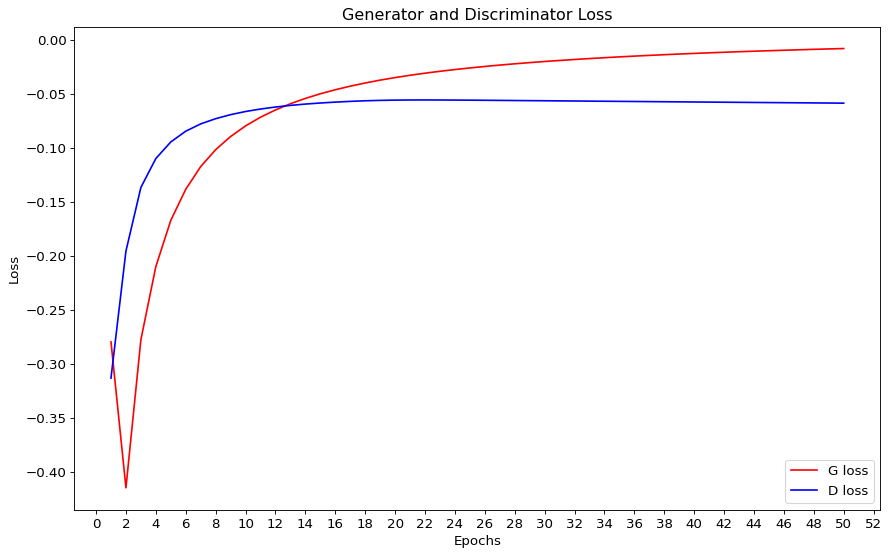

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(13, 8), dpi=80, facecolor='w', edgecolor='k')
epochs = range(1,num_epochs+1)
plt.plot(epochs, g_loss_history, 'r', label='G loss')
plt.plot(epochs, d_loss_history, 'b', label='D loss')
plt.title('Generator and Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
font = {'family' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.locator_params(axis='x', nbins=50)
plt.show()

As we can see, for first 2 epochs G loss has been dropping while D loss rised up. D loss has stabilized after about 12th epoch, and G loss has been slowly approaching zero ever since. Convergence at the point of zero is a goal here. Note that we can track the improvements in generated samples quality by simply looking at D loss. The Wasserstein distance (or at least an approximation of it used for WGANs) shows the minimum cost needed to turn one distribution into another, i.e. the cost of turning generated samples into real ones. As it comes close to zero, there's a very little cost.

We could've added minus sign for interpretabilty, then our loss graph would've looked something close to this (taken from one of the other experiments):

![Замещающий текст](https://drive.google.com/uc?id=1g-jzO3OrWzRs69Eyj04LEr3HSK7OxTTW) 

# Test samples

In [ ]:
num_test_samples = 100
test_noise = noise(num_test_samples)

generator.eval()

test_sent = generator(test_noise)
test_sent = test_sent.data.cpu()

similarities = [] # for tracking cosine similarities
  
print('_'*40)
for i in test_sent:
  print(' '.join([model.wv.most_similar([y], topn=1)[0][0] for y in i.numpy()]))
  print(' '.join([str(model.wv.most_similar([y], topn=1)[0][1]) for y in i.numpy()]))
  similarities.append([model.wv.most_similar([y], topn=1)[0][1] for y in i.numpy()])
  
print('_'*40)

________________________________________
<s> hi you a nothing need asked
0.9867405891418457 0.7354263067245483 0.7255404591560364 0.711334228515625 0.674310564994812 0.7014637589454651 0.6290768384933472
<s> driver 's the holiday japanes general
0.9972867965698242 0.7472301721572876 0.8412714004516602 0.8582613468170166 0.9040743112564087 0.7364182472229004 0.7678704261779785
<s> mean treatment is it enjoy manage
0.9934594631195068 0.8233360052108765 0.8476752638816833 0.7870933413505554 0.7354068160057068 0.7818579077720642 0.8183748722076416
<s> wondering is the sixth . </s>
0.9908275604248047 0.8249478936195374 0.8057514429092407 0.7402244210243225 0.83408123254776 0.7911545634269714 0.7911380529403687
<s> i 'd like a brooch .
0.996167004108429 0.9842103719711304 0.8308597207069397 0.807945191860199 0.8359864354133606 0.8725513815879822 0.8606743216514587
<s> where is n't enter hayakawa .
0.9953130483627319 0.7550404667854309 0.7876648902893066 0.7896497249603271 0.8516530990600586 

It is clearly noticeble that most of the generated samples are still pretty meaningless and non-coherent. However, there are some relatively successful sentences:

\<s> i 'd like a brooch .

\<s> can you arrange a manchester program

\<s> i 'd kindly confiscate born .

\<s> is there foreign tastes brochure ?

\<s> can you favor a souvenir loan

\<s> the tooth is warm . \</s>

\<s> i am grey portion of .

\<s> i am gonna enter everything .

\<s> do i have a towel red

\<s> i 'd like to withdraw .

\<s> hello , i catch the connection

\<s> it 's the slope . \</s>

\<s> it 's kindly kindly . \</s>

\<s> it 's says thursday . \</s>

\<s> i 'd like a adult exposure

\<s> could you remove the cheapest program

\<s> could you continue the oxford cruise

\<s> do you have a seafood rush

\<s> i 'd like to ride ?

\<s> do you have a hat wishes

\<s> i 'd like slide disembarkation .

\<s> i 'd like a perm .

\<s> do you prefer some diving newspaper

\<s> i shall arrange a spoon .

For comparison, here are the examples of generated sentences from the original paper (note they also have batches of size 100, but provide only some of generated sentences):

![Замещающий текст](https://drive.google.com/uc?id=1tb0VZtU0iDYf-_LdQZ3sBpex0Qc2D4FQ)











While it is hard to imagine real-life situations suiting for some of these phrases to be actually pronounced (to be fair, same applies to some of the sentences generated by GPT-3 that are too far away from strting user sequences), it's important to notice overall lexical consistency within them. E.g., there's not much meaning in the sentence 'I shall arrange a spoon", but it's valid in terms of preserving part of speech sequence (pronoun - auxiliary verb - verb - article - noun). Say, instead of "arrange" we could've had "pick" or "use"- which brings us to the problem of interpretation quality. While with images (primary GANs area of appliance) there's one reliable way to estimate quality of generated samples (G output is channel-splitted pixel values used directly to draw an image), it's not that simple with text. Using word embeddings allows for immediate converting continious values into human-readable text, but this algorithm isn't a direct depiction (as with images and pixel values which are two forms of the same thing), instead it results from previous training and relies on imperfect vector representation.

Parameter used for such transformation is cosine similarity, ranging from 0 to 1, zero meaning 90° between word vectors (absolute dissimilarity), and one being 0° (same word). Needless to say that word context is not completely reliable source of data for deriving vector values (and therefore cosine similarity), as same context often contains words of completely different meaning and lexical characteristics (e.g. belonging to different parts of speech). It requires from generator to produce embeddings with cosine similarity perfecctly close to 1, otherwise they could be easily confused with other words by nearest neighbor algorithm, thus breaking sentence coherence.

Average cosine similarity of vectors in test sentences

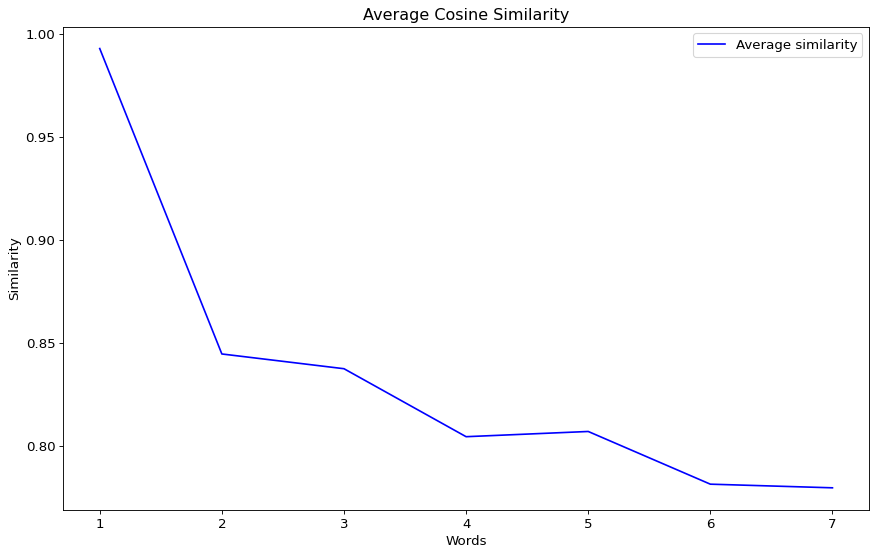

In [ ]:
# average similarity of each word and its nearest neighbor in the corpus 
# among 100 generated sentences
mean_sim = np.average(np.array(similarities), axis=0)

figure(num=None, figsize=(13, 8), dpi=80, facecolor='w', edgecolor='k')
words= range(1,8)
plt.plot(words, mean_sim, 'b', label='Average similarity')
plt.title('Average Cosine Similarity')
plt.xlabel('Words')
plt.ylabel('Similarity')
plt.legend()
font = {'family' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.show()

Clearly, the model easily learns that the sentence should start with `<s>`, and loses its confidence as it approaches the end of the sentence. It's somewhat similar to the results obtained by the authors of the original paper, however presented version of GAN seems to have less randomness in its output, with even the 7th word having a neighbor at `.75` similarity, while original GAN2vec model produces vectors of varying directions:

![Замещающий текст](https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_14%2Fproject_348561%2Fimages%2Fx4.png)

Cosine similarity drawbacks

Here are two examples of cosine similarity based nearest neighbours. None of the top 10 words closest to "home" from the created embedding matrix have common meaning with "home". Moreover, 3 of them wouldn't fit the sentence as the ones from the other parts of speech. As for "walk", only "cross" and "fly" resemble the original word.

In [ ]:
model.wv.most_similar('home')

[('bellboy', 0.8423759937286377),
 ('cab', 0.8341994881629944),
 ('dressed', 0.829531192779541),
 ('somebody', 0.8268216848373413),
 ('directly', 0.8247125744819641),
 ('message', 0.8222715854644775),
 ('sheraton', 0.8159037828445435),
 ('schedule', 0.8151955604553223),
 ('filled', 0.8134772181510925),
 ('security', 0.8132890462875366)]

In [ ]:
model.wv.most_similar('walk')

[('blocks', 0.8287975788116455),
 ('foot', 0.8274565935134888),
 ('minutes', 0.7859851121902466),
 ('ship', 0.7733632326126099),
 ('waist', 0.7723942995071411),
 ('cross', 0.7685551643371582),
 ('slow', 0.7651995420455933),
 ('straight', 0.7565125226974487),
 ('square', 0.7558601498603821),
 ('fly', 0.7541272640228271)]

For comparison, here are the closest neighbors for same words using pre-trained Glove embedding matrix of 50 dimensions. As we can see, in case of "home" nothing useful could be extracted here either, but we clearly have some improvements with "walk". So it could be reasonable to consider a possibility of taking advamtage of pre-trained embeddings rather than the ones trained directly on the dataset being used. It also could've been easier if the authors of the original paper had provided us with the exact methods and hyperparameters (e.g. context window size) they have used for embeddings training.

In [ ]:
import gensim
from gensim.models import KeyedVectors

filename = 'glove.6B.50d.txt.word2vec'
model1 = KeyedVectors.load_word2vec_format(filename, binary=False)

print(model1.wv.most_similar('home'))
print(model1.wv.most_similar('walk'))

[('leaving', 0.8598472476005554), ('went', 0.8544255495071411), ('where', 0.8208473920822144), ('now', 0.8191918134689331), ('rest', 0.8126111626625061), ('came', 0.8117709159851074), ('just', 0.8096145391464233), ('back', 0.8092808127403259), ('next', 0.8087299466133118), ('run', 0.8085863590240479)]
[('walking', 0.9026178121566772), ('walks', 0.8258365988731384), ('walked', 0.7914988994598389), ('ride', 0.7764881253242493), ('waiting', 0.773319661617279), ('go', 0.7616651654243469), ('sit', 0.7587370276451111), ('going', 0.7516138553619385), ('just', 0.7488577365875244), ('halfway', 0.7466045022010803)]



It seems like provided that embeddings will still be used, further research should be made in the area of developing the interpretation algorithm that would be more tolerant to variance in the generator output, shifting the burden from GAN model itself to output data converting. This process could be artificial in its nature, but it would compensate for a problem of text-numeric value converting (e.g. we could try to use Word Mover’s Distance instead of cosine similarity when picking nearest neighbors).

On the other hand, improving the model is always a desirable option, and it could be possible to include a differetiable function of choosing values with maximum cosine similarity for generated samples to either output layer of the generator (preferrably), or input layer of the discriminator, so that the discriminator (critic) would see the same picture we are seeing when extracting word embeddings turing training and inference.